# Monty Hall Environment

> L'agent est un candidat au jeu Monty Hall, Il doit prendre 2 décisions successives. Dans cet 
environnement, il y a 3 portes A, B et C. Au démarrage de l'environnement, une porte est tirée au hasard 
de manière cachée pour l'agent, il s'agit de la porte gagnante. La première action de l'agent est de choisir 
une porte parmi les trois portes. Ensuite, une porte parmi les 2 restantes non choisies par l'agent est 
retirée du jeu, il s'agit forcément d'une porte non gagnante. L'agent ensuite doit effectuer une nouvelle 
action : choisir de conserver la porte choisie au départ ou changer pour la porte restante. Une fois le choix 
fait, la porte choisie est 'ouverte' et l'on découvre si elle était gagnante (reward de 1.0) ou non (reward de 
0.0).


In [1]:
import numpy as np
from typing import List, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt

# Classe MontyHall Level1

In [2]:
from montyhall import MontyHall

# Exemple de partie manuelle

In [3]:
# Initialisation de l'environnement
env = MontyHall()

# Réinitialisation de l'environnement
initial_state = env.reset()
print(f"Initial state: {env.index_to_state(initial_state)}")

# Étape 1: L'agent choisit une porte initiale
initial_choice = np.random.randint(env.num_doors)
print(f"Agent chooses door: {initial_choice}")

# Mise à jour de l'environnement avec le choix initial
state_after_first_choice, _, _ = env.step(initial_choice)
env.display()

# Étape 2: Une porte non gagnante et non choisie est ouverte
# (Déjà géré par l'environnement dans step)
print(f"Opened door: {env.opened_door}")

# Étape 3: L'agent décide de rester ou de changer
# Supposons que l'agent décide de changer (action = 1)
second_action = 1  # 0 pour rester, 1 pour changer

# Mise à jour de l'environnement avec la deuxième action
final_state, reward, done = env.step(second_action)
env.display()

# Résultat final
print(f"Final state: {env.index_to_state(final_state)}")
print(f"Reward: {reward} (1.0 if win, 0.0 if lose)")


Initial state: (None, None)
Agent chooses door: 0
Winning Door: 1, Selected Door: 0, Opened Door: 2
Opened door: 2
Winning Door: 1, Selected Door: 1, Opened Door: 2
Final state: (1, 2)
Reward: 1 (1.0 if win, 0.0 if lose)


# Algorithme Naïf Q-learning

L'algorithme naïf de Q-learning est une méthode d'apprentissage par renforcement sans modèle qui cherche à apprendre la politique optimale pour un agent en explorant et en exploitant un environnement. Cet algorithme utilise une table de valeurs Q pour stocker et mettre à jour les estimations des récompenses futures attendues pour chaque paire état-action. Voici les étapes clés de cet algorithme :

1. **Initialisation** : La table Q est initialement remplie de valeurs arbitraires, et ces valeurs sont progressivement ajustées à travers les épisodes d'apprentissage.

2. **Choix des actions** : À chaque étape, l'agent choisit une action basée soit sur l'exploration (choix aléatoire) pour découvrir de nouvelles stratégies, soit sur l'exploitation (choisir l'action avec la valeur Q la plus élevée pour l'état actuel) pour maximiser les récompenses.

3. **Mise à jour de Q** : Après avoir pris une action, l'agent observe la récompense obtenue et le nouvel état atteint. La valeur Q pour la paire état-action est ensuite mise à jour en utilisant la formule :
   \[
   Q(s, a) = Q(s, a) + \alpha \left[r + \gamma \max_{a'} Q(s', a') - Q(s, a)\right]
   \]
   où \( \alpha \) est le taux d'apprentissage, \( \gamma \) est le facteur de dépréciation, \( r \) est la récompense observée, \( s' \) est le nouvel état, et \( a' \) est la meilleure action possible dans le nouvel état.

4. **Répétition** : Ces étapes sont répétées pour de nombreux épisodes jusqu'à ce que la table Q converge vers une approximation de la fonction de valeur optimale, permettant à l'agent de suivre la politique optimale déduite de Q.

L'algorithme de Q-learning est particulièrement utile pour les problèmes avec un espace d'état et d'action discrets et peut être appliqué à une variété de tâches d'apprentissage et de décision.


100%|██████████| 10000/10000 [00:00<00:00, 77802.54it/s]


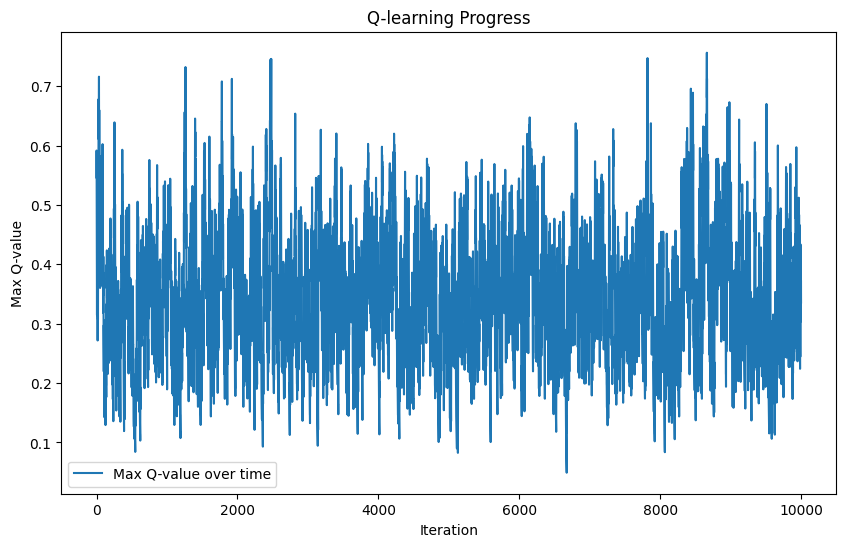

({0: 0}, {0: {0: 0.33572320487132035, 1: 0.24433805447509152}})

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def naive_q_learning_gridworld(env_type, alpha: float = 0.1, epsilon: float = 0.1, gamma: float = 0.999, nb_iter: int = 100000):
    Q = {}
    max_Q_values = []

    env = env_type()
    for it in tqdm(range(nb_iter)):
        env.reset()

        while not env.is_game_over():
            s = env.state_id()
            aa = env.available_actions()

            if s not in Q:
                Q[s] = {}
                for a in aa:
                    Q[s][a] = np.random.random()  # Initialize Q-values for each state-action pair

            # Decide whether to explore or exploit
            if np.random.random() < epsilon:
                a = np.random.choice(aa)
            else:
                # Choose the best action based on current Q-values
                q_s = [Q[s][a] for a in aa]
                best_a_index = np.argmax(q_s)
                a = aa[best_a_index]

            prev_score = env.score()
            env.step(a)
            r = env.score() - prev_score

            s_p = env.state_id()
            aa_p = env.available_actions()

            if env.is_game_over():
                target = r
            else:
                if s_p not in Q:
                    Q[s_p] = {}
                    for a_p in aa_p:
                        Q[s_p][a_p] = np.random.random()
                q_s_p = [Q[s_p][a_p] for a_p in aa_p]
                max_a_p = np.max(q_s_p)
                target = r + gamma * max_a_p

            Q[s][a] = (1 - alpha) * Q[s][a] + alpha * target

        # Track the maximum Q-value
        max_Q = max([max(actions.values()) for actions in Q.values()])
        max_Q_values.append(max_Q)

    # Extract policy from Q-values
    Pi = {}
    for s, actions in Q.items():
        best_a = max(actions, key=actions.get)
        Pi[s] = best_a

    # Plot the evolution of the maximum Q-value
    plt.figure(figsize=(10, 6))
    plt.plot(max_Q_values, label='Max Q-value over time')
    plt.xlabel('Iteration')
    plt.ylabel('Max Q-value')
    plt.title('Q-learning Progress')
    plt.legend()
    plt.show()

    return Pi, Q
# Example usage:
env = MontyHall
naive_q_learning_gridworld(env_type=env, nb_iter=10000)

# Algorithme Monte Carlo avec départs exploratoires (ES)

L'algorithme de Monte Carlo avec départs exploratoires (ES) est une technique d'apprentissage par renforcement qui permet d'estimer la politique optimale en utilisant l'échantillonnage complet des retours (gains cumulés) de chaque épisode. Contrairement aux méthodes basées sur le temps différé comme Q-learning, les méthodes Monte Carlo ajustent les estimations de la politique uniquement à la fin de chaque épisode. Voici les étapes principales de cet algorithme :

1. **Initialisation** : La politique (Pi) et la table de valeurs Q sont initialisées. Pour chaque état, une action est choisie aléatoirement comme action par défaut. Un dictionnaire de retours est également initialisé pour stocker les retours accumulés pour chaque paire état-action.

2. **Départs exploratoires** : Chaque épisode commence dans un état initial choisi aléatoirement avec une action également choisie aléatoirement. Cela assure que toutes les paires état-action ont une chance d'être explorées suffisamment.

3. **Génération de l'épisode** : L'agent suit la politique actuelle sauf pour le premier choix qui est aléatoire. L'épisode est enregistré sous forme de séquence de triplets (état, action, récompense).

4. **Calcul du retour** : À la fin de l'épisode, le retour pour chaque étape est calculé en remontant depuis la fin de l'épisode jusqu'au début, en utilisant le facteur de dépréciation \( \gamma \). Le retour est le gain cumulé à partir de cette étape jusqu'à la fin de l'épisode.

5. **Mise à jour de Q et de la politique** :
   - **Mise à jour de Q** : Pour chaque paire état-action unique rencontrée dans l'épisode, le retour est ajouté à la liste des retours correspondants et la valeur Q est mise à jour comme la moyenne de ces retours.
   - **Mise à jour de la politique** : Pour chaque état visité, la politique est mise à jour pour choisir l'action qui maximise la valeur Q estimée pour cet état.

6. **Répétition** : Le processus est répété pour un grand nombre d'épisodes pour permettre à la politique de converger vers la politique optimale.

Cet algorithme est particulièrement utile dans les environnements avec des dynamiques simples où la méthode des départs exploratoires est faisable. Il est aussi bien adapté aux situations où il est possible de simuler l'environnement pour générer des épisodes avec des conditions de départ arbitraires.


100%|██████████| 10000/10000 [00:02<00:00, 3370.43it/s]


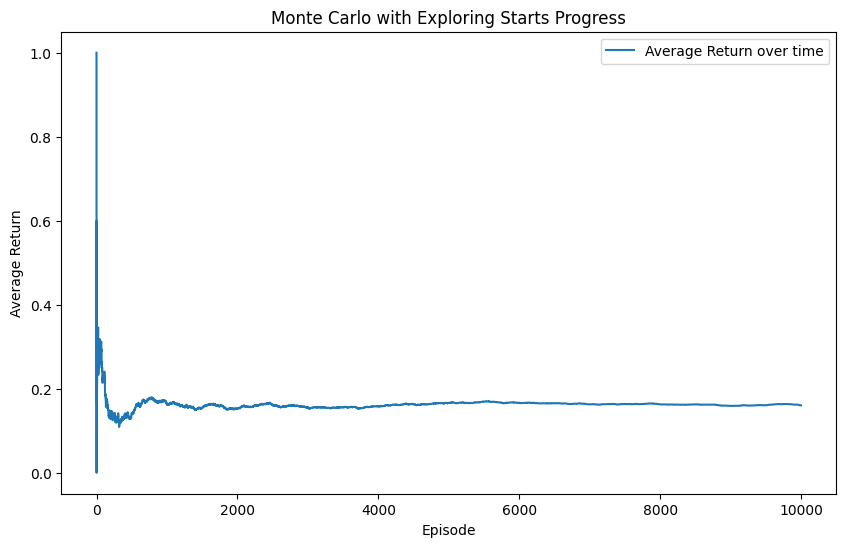

{0: 1}

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def naive_monte_carlo_with_exploring_starts(env_type, gamma=0.999, nb_iter=10000, max_steps=10):
    Pi = {}
    Q = {}
    Returns = {}
    avg_returns = []

    for it in tqdm(range(nb_iter)):
        env = env_type.from_random_state()  # Assurez-vous que cette méthode initialise correctement

        is_first_action = True
        trajectory = []
        steps_count = 0
        while not env.is_game_over() and steps_count < max_steps:
            s = env.state_id()
            aa = env.available_actions()

            if s not in Pi:
                Pi[s] = np.random.choice(aa)

            if is_first_action:
                a = np.random.choice(aa)
                is_first_action = False
            else:
                a = Pi[s]

            prev_score = env.score()
            env.step(a)
            r = env.score() - prev_score

            trajectory.append((s, a, r, aa))
            steps_count += 1

        G = 0
        for (t, (s, a, r, aa)) in reversed(list(enumerate(trajectory))):
            G = gamma * G + r

            if all(map(lambda triplet: triplet[0] != s or triplet[1] != a, trajectory[:t])):
                if (s, a) not in Returns:
                    Returns[(s, a)] = []
                Returns[(s, a)].append(G)
                Q[(s, a)] = np.mean(Returns[(s, a)])

                best_a = None
                best_a_score = 0.0
                for a in aa:
                    if (s, a) not in Q:
                        Q[(s, a)] = np.random.random()
                    if best_a is None or Q[(s, a)] > best_a_score:
                        best_a = a
                        best_a_score = Q[(s, a)]

                Pi[s] = best_a

        # Calculate the average return for visualization
        avg_return = np.mean([np.mean(ret) for ret in Returns.values()])
        avg_returns.append(avg_return)

    # Plot the average return over time
    plt.figure(figsize=(10, 6))
    plt.plot(avg_returns, label='Average Return over time')
    plt.xlabel('Episode')
    plt.ylabel('Average Return')
    plt.title('Monte Carlo with Exploring Starts Progress')
    plt.legend()
    plt.show()

    return Pi



naive_monte_carlo_with_exploring_starts(env, nb_iter=10000)

# Algorithme On-policy First visit Monte Carlo control

100%|██████████| 10000/10000 [00:03<00:00, 2748.93it/s]


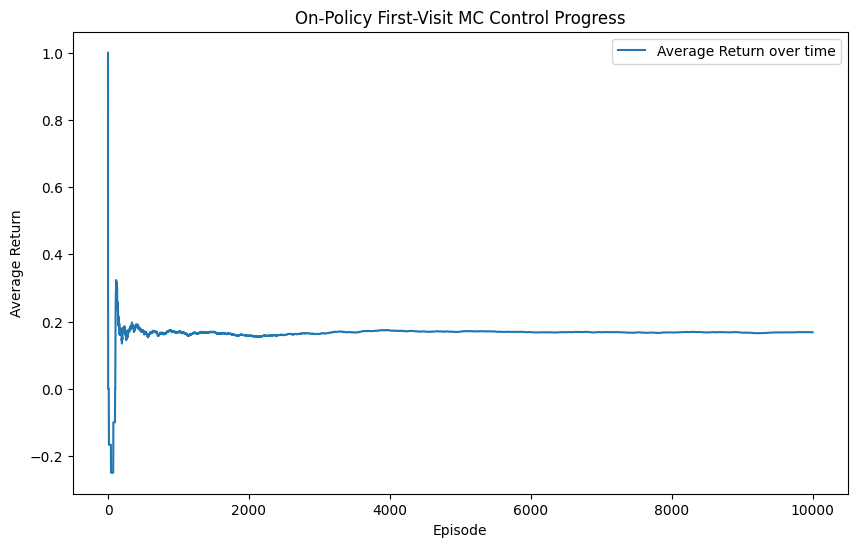

{0: 1}

In [9]:
from collections import defaultdict
def on_policy_first_visit_mc_control(env_type, gamma=0.999, epsilon=0.1, nb_iter=10000, max_steps=10):
    Pi = {}
    Q = defaultdict(lambda: 0.0)
    Returns = defaultdict(list)
    avg_returns = []

    for it in tqdm(range(nb_iter)):
        env = env_type.from_random_state()
        trajectory = []
        steps_count = 0

        while not env.is_game_over() and steps_count < max_steps:
            s = env.state_id()
            aa = env.available_actions()

            if np.random.random() < epsilon or s not in Pi:
                a = np.random.choice(aa)
            else:
                a = Pi[s]

            prev_score = env.score()
            env.step(a)
            r = env.score() - prev_score

            trajectory.append((s, a, r, aa))
            steps_count += 1

        G = 0
        visited_state_action_pairs = set()
        for (s, a, r, aa) in reversed(trajectory):
            G = gamma * G + r

            if (s, a) not in visited_state_action_pairs:
                visited_state_action_pairs.add((s, a))
                Returns[(s, a)].append(G)
                Q[(s, a)] = np.mean(Returns[(s, a)])

                best_a = max(aa, key=lambda action: Q[(s, action)])
                Pi[s] = best_a

        # Calculate the average return for visualization
        avg_return = np.mean([np.mean(ret) for ret in Returns.values()])
        avg_returns.append(avg_return)

    # Plot the average return over time
    plt.figure(figsize=(10, 6))
    plt.plot(avg_returns, label='Average Return over time')
    plt.xlabel('Episode')
    plt.ylabel('Average Return')
    plt.title('On-Policy First-Visit MC Control Progress')
    plt.legend()
    plt.show()

    return Pi




on_policy_first_visit_mc_control(env, nb_iter=10000)

# Off Policy First visit Monte Carlo Control

100%|██████████| 10000/10000 [00:00<00:00, 48338.40it/s]


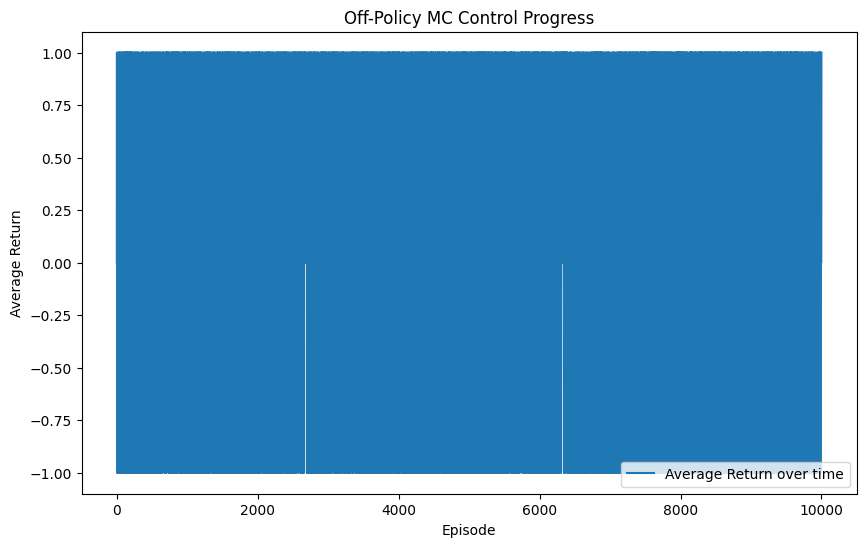

{0: 1}

In [13]:
def off_policy_mc_control(env_type, gamma=0.999, nb_iter=10000, max_steps=10):
    Q = defaultdict(lambda: 0.0)
    C = defaultdict(lambda: 0.0)
    b = defaultdict(lambda: 1.0)  # behavior policy (random)
    Pi = {}
    avg_returns = []

    for it in tqdm(range(nb_iter)):
        env = env_type.from_random_state()
        trajectory = []
        steps_count = 0

        while not env.is_game_over() and steps_count < max_steps:
            s = env.state_id()
            aa = env.available_actions()

            a = np.random.choice(aa)
            prev_score = env.score()
            env.step(a)
            r = env.score() - prev_score

            trajectory.append((s, a, r))
            steps_count += 1

        G = 0
        W = 1.0
        for (s, a, r) in reversed(trajectory):
            G = gamma * G + r
            C[(s, a)] += W
            Q[(s, a)] += (W / C[(s, a)]) * (G - Q[(s, a)])
            
            Pi[s] = max(env.available_actions(), key=lambda action: Q[(s, action)])
            
            if a != Pi[s]:
                break
            
            W *= 1.0 / b[(s, a)]

        # Calculate the average return for visualization
        avg_return = np.mean([G for _, _, G in trajectory])
        avg_returns.append(avg_return)

    # Plot the average return over time
    plt.figure(figsize=(10, 6))
    plt.plot(avg_returns, label='Average Return over time')
    plt.xlabel('Episode')
    plt.ylabel('Average Return')
    plt.title('Off-Policy MC Control Progress')
    plt.legend()
    plt.show()

    return Pi

off_policy_mc_control(env, nb_iter=10000)


# Sarsa

2024-07-24 10:35:59.003785: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-07-24 10:36:01.412494: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-24 10:36:01.422668: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-07-24 10:36:01.747789: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-24 10:36:01.748294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4060 Laptop GPU computeCapability: 8.9
coreClock: 2.37GHz coreCount: 24 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 238.45GiB/s
2024-07-24 10:36:01.748331: I tensorflow/stream_execu

Episode 1, State: 0, Action: 1, Next State: 4, Reward: 0, Done: False


2024-07-24 10:36:07.600094: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-07-24 10:36:07.605586: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2994310000 Hz
2024-07-24 10:36:07.672357: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Episode 1, State: 4, Action: 1, Next State: 7, Reward: 1, Done: True
Episode 2, State: 0, Action: 0, Next State: 3, Reward: 0, Done: False
Episode 2, State: 3, Action: 0, Next State: 3, Reward: 0, Done: True
Episode 3, State: 0, Action: 0, Next State: 2, Reward: 0, Done: False
Episode 3, State: 2, Action: 1, Next State: 8, Reward: 1, Done: True
Episode 4, State: 0, Action: 0, Next State: 3, Reward: 0, Done: False
Episode 4, State: 3, Action: 0, Next State: 3, Reward: 0, Done: True
Episode 5, State: 0, Action: 0, Next State: 2, Reward: 0, Done: False
Episode 5, State: 2, Action: 1, Next State: 8, Reward: 1, Done: True
Episode 6, State: 0, Action: 0, Next State: 3, Reward: 0, Done: False
Episode 6, State: 3, Action: 1, Next State: 6, Reward: 0, Done: True
Episode 7, State: 0, Action: 1, Next State: 4, Reward: 0, Done: False
Episode 7, State: 4, Action: 1, Next State: 7, Reward: 1, Done: True
Episode 8, State: 0, Action: 0, Next State: 2, Reward: 0, Done: False
Episode 8, State: 2, Action

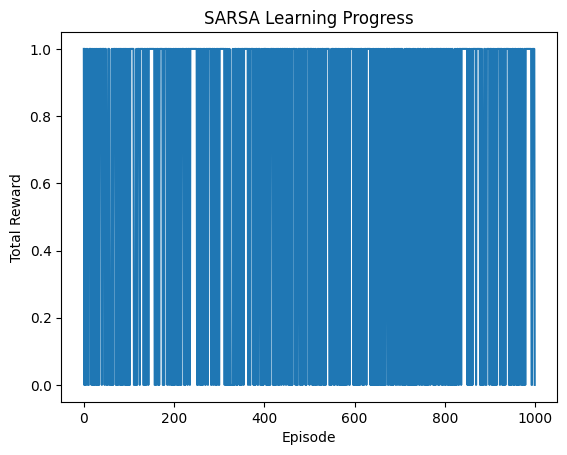

Optimal Policy (State, Action):
State: 0, Action: 0
State: 1, Action: 1
State: 2, Action: 1
State: 3, Action: 1
State: 4, Action: 1
State: 5, Action: 1
State: 6, Action: 1
State: 7, Action: 1
State: 8, Action: 1
State: 9, Action: 1
State: 10, Action: 1
State: 11, Action: 1


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def build_model(state_size, action_size):
    model = Sequential()
    model.add(Dense(24, input_dim=state_size, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def sarsa(env_class, num_episodes, alpha, gamma, epsilon):
    env = env_class()
    state_size = env.num_states()
    action_size = env.num_actions()
    model = build_model(state_size, action_size)

    rewards_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        # Encode initial state as one-hot
        state_one_hot = np.eye(state_size)[state:state + 1]
        action = np.random.choice(env.available_actions()) if np.random.rand() < epsilon else np.argmax(model.predict(state_one_hot)[0])

        while not done:
            next_state, reward, done = env.step(action)
            next_state_one_hot = np.eye(state_size)[next_state:next_state + 1]

            # Debug: Display next state
            print(f"Episode {episode + 1}, State: {state}, Action: {action}, Next State: {next_state}, Reward: {reward}, Done: {done}")

            next_action = np.random.choice(env.available_actions()) if np.random.rand() < epsilon else np.argmax(model.predict(next_state_one_hot)[0])

            target = reward + gamma * model.predict(next_state_one_hot)[0][next_action] if not done else reward
            target_f = model.predict(state_one_hot)
            target_f[0][action] = (1 - alpha) * target_f[0][action] + alpha * target

            model.fit(state_one_hot, target_f, epochs=1, verbose=0)

            state = next_state
            state_one_hot = next_state_one_hot
            action = next_action
            total_reward += reward

        rewards_per_episode.append(total_reward)

    # Plot the rewards per episode
    plt.plot(rewards_per_episode)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('SARSA Learning Progress')
    plt.show()

    return model

def display_optimal_policy(env_class, model):
    env = env_class()
    state_size = env.num_states()
    action_size = env.num_actions()
    optimal_policy = []

    for state in range(state_size):
        state_one_hot = np.eye(state_size)[state:state + 1]
        action = np.argmax(model.predict(state_one_hot)[0])
        optimal_policy.append((state, action))

    print("Optimal Policy (State, Action):")
    for state, action in optimal_policy:
        print(f"State: {state}, Action: {action}")

# Parameters for SARSA
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 0.1  # Exploration rate
num_episodes = 1000  # Number of episodes

# Create the environment and run the SARSA algorithm
model = sarsa(MontyHall, num_episodes, alpha, gamma, epsilon)

# Display the optimal policy found
display_optimal_policy(MontyHall, model)


In [16]:
optimal_policy = display_optimal_policy(MontyHall, model)

Optimal Policy (State, Action):
State: 0, Action: 0
State: 1, Action: 1
State: 2, Action: 1
State: 3, Action: 1
State: 4, Action: 1
State: 5, Action: 1
State: 6, Action: 1
State: 7, Action: 1
State: 8, Action: 1
State: 9, Action: 1
State: 10, Action: 1
State: 11, Action: 1


# Dyna Q

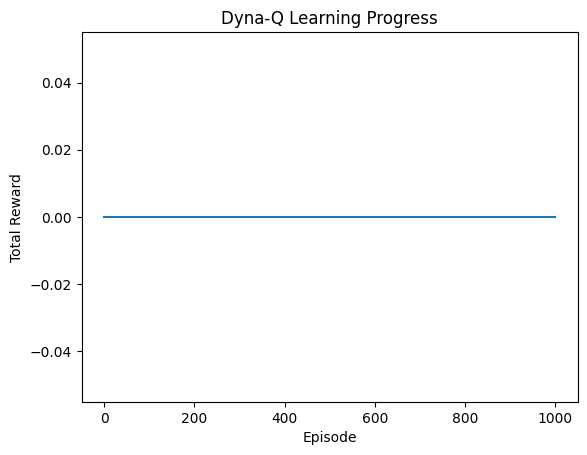

State 0: [0.0, 0.0]
State 1: [0.0, 0.0]
State 2: [0.0, 0.0]
State 3: [0.0, 0.0]
State 4: [0.0, 0.0]
State 5: [0.0, 0.0]
State 6: [0.0, 0.0]
State 7: [0.0, 0.0]
State 8: [0.0, 0.0]
State 9: [0.0, 0.0]
State 10: [0.0, 0.0]
State 11: [0.0, 0.0]
State 0: Stick
State 1: Stick
State 2: Stick
State 3: Stick
State 4: Stick
State 5: Stick
State 6: Stick
State 7: Stick
State 8: Stick
State 9: Stick
State 10: Stick
State 11: Stick


In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt

def epsilon_greedy_policy(Q, state, epsilon, available_actions):
    if random.uniform(0, 1) < epsilon:
        return random.choice(available_actions)
    else:
        return max(available_actions, key=lambda x: Q[state][x])

def dyna_q(env_class, num_episodes, alpha, gamma, epsilon, planning_steps):
    env = env_class()
    Q = {state: [0.0, 0.0] for state in range(env.num_states())}  # Only 2 actions: stick (0) or switch (1)
    model = {state: {} for state in range(env.num_states())}
    rewards_per_episode = []

    for episode in range(num_episodes):
        env.reset()
        state = env.state_id()
        available_actions = env.available_actions()
        action = epsilon_greedy_policy(Q, state, epsilon, available_actions)
        total_reward = 0

        while not env.is_game_over():
            next_state, reward, done = env.step(action)
            next_available_actions = env.available_actions()
            next_action = epsilon_greedy_policy(Q, next_state, epsilon, next_available_actions)

            # Update Q
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])

            # Update the model
            model[state][action] = (reward, next_state)

            # Planning
            for _ in range(planning_steps):
                sampled_state = random.choice(list(model.keys()))
                if not model[sampled_state]:
                    continue
                sampled_action = random.choice(list(model[sampled_state].keys()))
                sampled_reward, sampled_next_state = model[sampled_state][sampled_action]

                Q[sampled_state][sampled_action] += alpha * (sampled_reward + gamma * max(Q[sampled_next_state]) - Q[sampled_state][sampled_action])

            state = next_state
            action = next_action
            total_reward += reward

        rewards_per_episode.append(total_reward)

    # Plot the rewards per episode
    plt.plot(rewards_per_episode)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Dyna-Q Learning Progress')
    plt.show()

    return Q

# Parameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 0.1  # Exploration rate
num_episodes = 1000  # Number of episodes
planning_steps = 5  # Number of planning steps

# Create the environment and run the Dyna-Q algorithm
env = MontyHall()
Q = dyna_q(env, num_episodes, alpha, gamma, epsilon, planning_steps)

# Display the Q-values
for state, actions in Q.items():
    print(f"State {state}: {actions}")

# Display the optimal policy found
action_symbols = ['Stick', 'Switch']
for state in range(env.num_states()):
    best_action = np.argmax(Q[state])
    print(f"State {state}: {action_symbols[best_action]}")


# Policy et Value Iteration

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

class PolicyIteration:
    def __init__(self, env_class, gamma=0.99, theta=1e-3):
        self.env_class = env_class
        self.gamma = gamma
        self.theta = theta
        self.env = env_class()
        self.num_states = self.env.num_states()
        self.num_actions = self.env.num_actions()

    def run(self) -> Tuple[List[int], List[float]]:
        policy = np.random.choice(self.num_actions, size=self.num_states)
        V = np.zeros(self.num_states)
        iteration = 0
        value_history = []

        while True:
            V = self.policy_evaluation(policy, V)
            policy_stable = self.policy_improvement(policy, V)
            value_history.append(V.copy())
            iteration += 1
            if policy_stable:
                break

        self.plot_value_history(value_history, 'Policy Iteration Value Function Improvement')
        return policy, V

    def policy_evaluation(self, policy, V):
        while True:
            delta = 0
            for s in range(self.num_states):
                v = V[s]
                new_v = 0
                for a in range(self.num_actions):
                    if policy[s] == a:
                        for next_state in range(self.num_states):
                            for r_index in range(self.env.num_rewards()):
                                prob = self.env.p(s, a, next_state, r_index)
                                reward = self.env.reward(r_index)
                                new_v += prob * (reward + self.gamma * V[next_state])
                delta = max(delta, abs(v - new_v))
                V[s] = new_v
            if delta < self.theta:
                break
        return V

    def policy_improvement(self, policy, V):
        policy_stable = True
        for s in range(self.num_states):
            chosen_a = policy[s]
            action_values = self.one_step_lookahead(s, V)
            best_a = np.argmax(action_values)
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = best_a
        return policy_stable

    def one_step_lookahead(self, state, V):
        A = np.zeros(self.num_actions)
        for a in range(self.num_actions):
            for next_state in range(self.num_states):
                for r_index in range(self.env.num_rewards()):
                    prob = self.env.p(state, a, next_state, r_index)
                    reward = self.env.reward(r_index)
                    A[a] += prob * (reward + self.gamma * V[next_state])
        return A

    def plot_value_history(self, value_history, title):
        plt.figure(figsize=(10, 6))
        for i, values in enumerate(value_history):
            plt.plot(values, label=f'Iteration {i}')
        plt.xlabel('State')
        plt.ylabel('Value')
        plt.title(title)
        plt.legend()
        plt.show()


class ValueIteration:
    def __init__(self, env_class, gamma=0.99, theta=1e-3):
        self.env_class = env_class
        self.gamma = gamma
        self.theta = theta
        self.env = env_class()
        self.num_states = self.env.num_states()
        self.num_actions = self.env.num_actions()

    def run(self) -> List[float]:
        V = np.zeros(self.num_states)
        iteration = 0
        value_history = []

        while True:
            delta = 0
            value_history.append(V.copy())
            for s in range(self.num_states):
                v = V[s]
                action_values = self.one_step_lookahead(s, V)
                V[s] = max(action_values)
                delta = max(delta, abs(v - V[s]))
            iteration += 1
            if delta < self.theta:
                break

        self.plot_value_history(value_history, 'Value Iteration Value Function Improvement')
        return V

    def one_step_lookahead(self, state, V):
        A = np.zeros(self.num_actions)
        for a in range(self.num_actions):
            for next_state in range(self.num_states):
                for r_index in range(self.env.num_rewards()):
                    prob = self.env.p(state, a, next_state, r_index)
                    reward = self.env.reward(r_index)
                    A[a] += prob * (reward + self.gamma * V[next_state])
        return A

    def plot_value_history(self, value_history, title):
        plt.figure(figsize=(10, 6))
        for i, values in enumerate(value_history):
            plt.plot(values, label=f'Iteration {i}')
        plt.xlabel('State')
        plt.ylabel('Value')
        plt.title(title)
        plt.legend()
        plt.show()



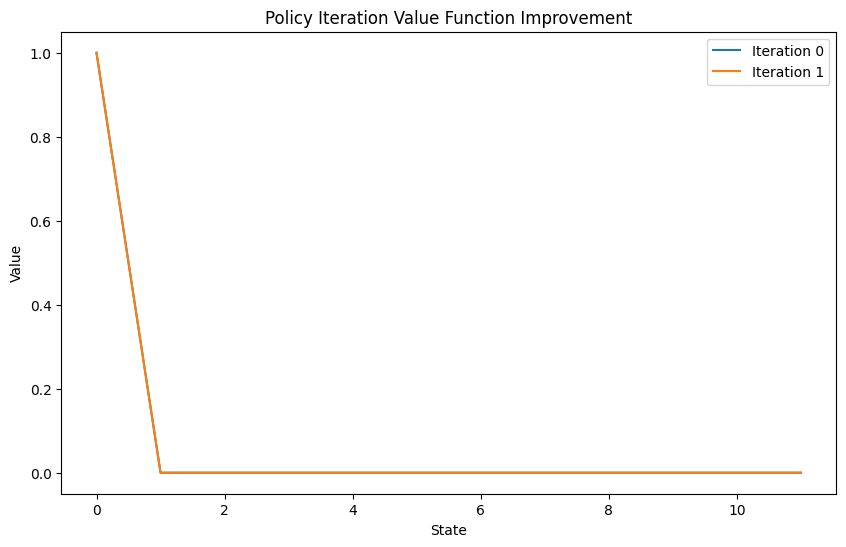

State 0: Stick
State 1: Stick
State 2: Stick
State 3: Stick
State 4: Stick
State 5: Stick
State 6: Stick
State 7: Stick
State 8: Stick
State 9: Stick
State 10: Stick
State 11: Stick


In [19]:
# Create the environment
env_class = MontyHall

# Run Policy Iteration
pi = PolicyIteration(env_class)
policy, V = pi.run()

# Display the optimal policy found
action_symbols = ['Stick', 'Switch']
for state in range(env_class().num_states()):
    print(f"State {state}: {action_symbols[policy[state]]}")


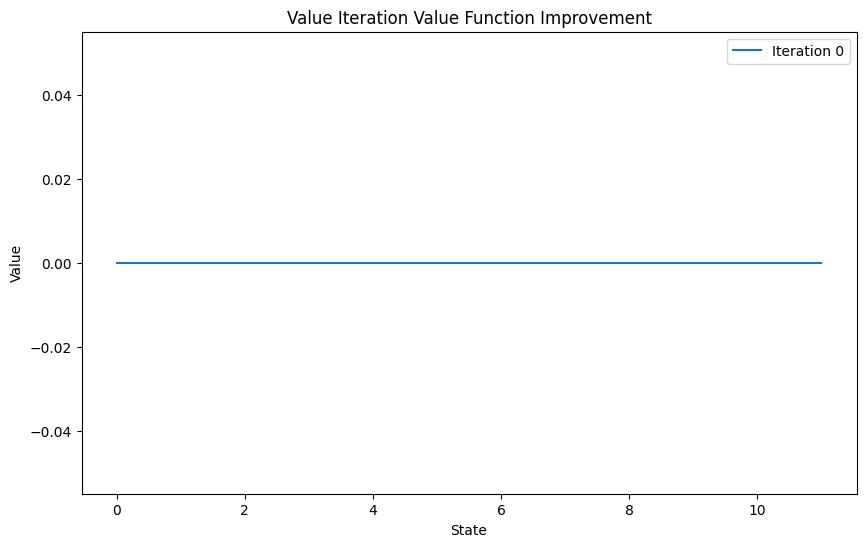

State 0: Value 0.0
State 1: Value 0.0
State 2: Value 0.0
State 3: Value 0.0
State 4: Value 0.0
State 5: Value 0.0
State 6: Value 0.0
State 7: Value 0.0
State 8: Value 0.0
State 9: Value 0.0
State 10: Value 0.0
State 11: Value 0.0


In [20]:
# Create the environment
env_class = MontyHall

# Run Value Iteration
vi = ValueIteration(env_class)
V = vi.run()

# Display the value function found
for state in range(env_class().num_states()):
    print(f"State {state}: Value {V[state]}")
